<a href="https://colab.research.google.com/github/mohammad-zoubi/Generative_modelling_for_melanoma_detection/blob/main/synthetic_data_evaluation/survey_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [3]:
# Import gt and label files
df_gt = pd.read_excel('/content/drive/MyDrive/ExJobb/survey_files/derm_survey.xlsx').sort_values(by='order')
df_labels= pd.read_csv('/content/drive/MyDrive/ExJobb/survey_files/responses_4_shummar.csv')

In [44]:
colors = ["#ddc7af","#d3a293", "#ba707e", "#995374", "#4f3159", "#231f37"]
sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

In [14]:
df_labels

,Timestamp,Username,Unnamed: 2,Diagnosis of lesion,Is this image synthetic?,Level of certainty:,Diagnosis of lesion.1,Is this image synthetic?.1,Level of certainty:.1,Diagnosis of lesion.2,...,Level of certainty:.197,Diagnosis of lesion.198,Is this image synthetic?.198,Level of certainty:.198,Diagnosis of lesion.199,Is this image synthetic?.199,Level of certainty:.199,"Overall how convincing were the ""fake"" images?",Any comments for us in regards to the images or the process of the survey?,"If you would like to receive the results from the survey and the report that it will contribute to, please leave your email:"
0,2022/04/22 6:37:24 PM GMT+2,anna_frosen@hotmail.com,NaN,invasive melanoma,Yes,NaN,invasive melanoma,Yes,NaN,benign melanoma,...,NaN,benign melanoma,Yes,NaN,benign melanoma,Yes,NaN,NaN,NaN,NaN
1,2022/04/27 9:27:56 AM GMT+2,sam.polesie@gmail.com,Dermatologist,not melanoma,Yes,4.0,not melanoma,No,4.0,not melanoma,...,3.0,not melanoma,Yes,2.0,not melanoma,Yes,3.0,I would say they were very convincing. Hair st...,When you say malignant melanoma you automatica...,sam.polesie@gmail.com
2,2022/05/11 9:44:50 AM GMT+2,noora.neittaanmaki@vgregion.se,Dermatologist,not melanoma,No,4.0,malignant melanoma,Yes,3.0,not melanoma,...,4.0,not melanoma,Yes,4.0,not melanoma,No,4.0,"Some pretty convincing, some clearly fake",The images should be bigger (whole screen),noora.neittaanmaki@vgregion.se
3,2022/05/02 9:29:14 AM GMT+2,lisa.l.sjoblom@vgregion.se,Lay person (i.e. non-medical),not melanoma,Yes,3.0,malignant melanoma,No,3.0,not melanoma,...,2.0,not melanoma,No,2.0,not melanoma,Yes,2.0,Hard to say when you don't have the correct an...,No,NaN
4,2022/05/09 3:46:24 PM GMT+2,juulia.suvilehto@gmail.com,Deep learning expert,not melanoma,No,3.0,malignant melanoma,No,3.0,not melanoma,...,2.0,not melanoma,No,3.0,not melanoma,Yes,3.0,very convincing! well done! I was mainly focus...,NaN,NaN


In [9]:
df_labels.iloc[0+1], df_labels.iloc[1+1], df_labels.iloc[2+1], df_labels.iloc[3+1] = df_labels.iloc[0+1], df_labels.iloc[3+1], df_labels.iloc[1+1], df_labels.iloc[2+1]

In [10]:
# Initialize empty arrays
certainty_matrix = np.zeros((4, 200))
weighted_certainty_matrix = np.zeros((4, 200))
diagnosis_matrix = np.zeros((4, 200))
synth_matrix = np.zeros((4, 200))
diagn_matrix = np.zeros((4, 200))
# [sam, lisa, juulia, noora]

In [11]:
# Convert labels from {0,1} to {-1,1}
synth_label_gt = 2*np.asarray(df_gt.synthetic) - 1
diagnosis_label_gt = 2*np.asarray(df_gt.label) - 1

In [12]:
tn_synth = np.zeros((4)) 
fp_synth = np.zeros((4))
fn_synth = np.zeros((4))
tp_synth = np.zeros((4))
acc_synth = np.zeros((4))

tn_diagn = np.zeros((4)) 
fp_diagn = np.zeros((4))
fn_diagn = np.zeros((4))
tp_diagn = np.zeros((4))
acc_diagn = np.zeros((4))

In [13]:
# place results in a matrix 
for i in range(1,5):
    answers_synth = df_labels.iloc[i][[q for q in list(df_labels) if q[:23]=='Is this image synthetic']]
    answers_diagnosis = df_labels.iloc[i][[q for q in list(df_labels) if q[:19]=='Diagnosis of lesion']]
    answers_certainty = df_labels.iloc[i][[q for q in list(df_labels) if q[:18]=='Level of certainty']]

    label_synth = np.asarray([1 if i == 'Yes' else -1 for i in answers_synth])
    label_diagnosis = np.asarray([1 if i == 'malignant melanoma' else -1 for i in answers_diagnosis])

    certainty_matrix[i-1, :] = answers_certainty
    diagnosis_matrix[i-1, :] = label_diagnosis
    synth_matrix[i-1, :] = label_synth
    diagn_matrix[i-1, :] = label_diagnosis
    tn_synth[i-1], fp_synth[i-1], fn_synth[i-1], tp_synth[i-1] = confusion_matrix(y_true=synth_label_gt, y_pred=label_synth).ravel()
    acc_synth[i-1] = accuracy_score(y_true=synth_label_gt, y_pred=label_synth)
    tn_diagn[i-1], fp_diagn[i-1], fn_diagn[i-1], tp_diagn[i-1] = confusion_matrix(y_true=diagnosis_label_gt, y_pred=label_diagnosis).ravel()
    acc_diagn[i-1] = accuracy_score(y_true=diagnosis_label_gt, y_pred=label_diagnosis)

weighted_certainty_matrix = 20*certainty_matrix/100 # Weighted after certainty level

In [27]:
synth_idx = np.where(synth_label_gt == 1)[0]
real_idx = np.where(synth_label_gt == -1)[0]

In [41]:
participant1 = 0
participant2 = 1

In [42]:
synth_mel_pred_p1 = diagnosis_matrix[participant1][synth_idx]
sytnh_mel_gt_p1 = diagnosis_label_gt[synth_idx]
real_mel_pred_p1 = diagnosis_matrix[participant1][real_idx]
real_mel_gt_p1 = diagnosis_label_gt[real_idx]

synth_mel_pred_p2 = diagnosis_matrix[participant2][synth_idx]
sytnh_mel_gt_p2 = diagnosis_label_gt[synth_idx]
real_mel_pred_p2 = diagnosis_matrix[participant2][real_idx]
real_mel_gt_p2 = diagnosis_label_gt[real_idx]

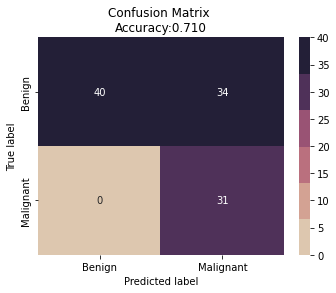

<Figure size 432x288 with 0 Axes>

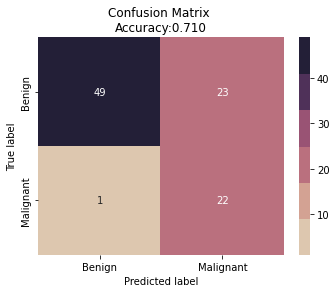

<Figure size 432x288 with 0 Axes>

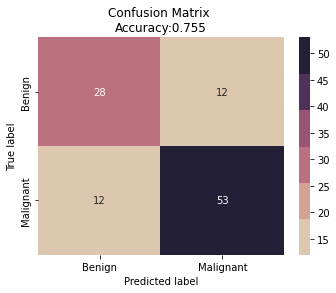

<Figure size 432x288 with 0 Axes>

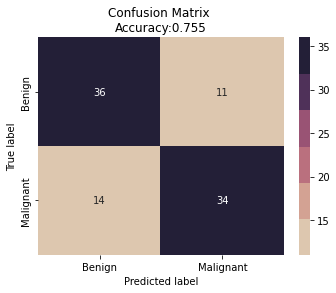

<Figure size 432x288 with 0 Axes>

In [48]:
confussion_matrix(sytnh_mel_gt_p1, synth_mel_pred_p1, acc_diagn[participant1])
confussion_matrix(real_mel_gt_p1, real_mel_pred_p1, acc_diagn[participant1])
confussion_matrix(sytnh_mel_gt_p2, synth_mel_pred_p2, acc_diagn[participant2])
confussion_matrix(real_mel_gt_p2, real_mel_pred_p2, acc_diagn[participant2])

In [47]:
def confussion_matrix(test, test_pred, test_accuracy):
    pred = np.round(test_pred)
    cm = confusion_matrix(test, pred)

    cm_df = pd.DataFrame(cm,
                        index = ['Benign','Malignant'], 
                        columns = ['Benign','Malignant'])

    fig = plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=colors)
    plt.title('Confusion Matrix \nAccuracy:{0:.3f}'.format(test_accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # writer.add_image('conf_matrix', fig)
    plt.savefig(os.path.join('classification_synth.png'))


In [130]:
# Print one value
idx = 2

answers_synth = df_labels.iloc[idx][[q for q in list(df_labels) if q[:23]=='Is this image synthetic']]
answers_diagnosis = df_labels.iloc[idx][[q for q in list(df_labels) if q[:19]=='Diagnosis of lesion']]
label_synth = np.asarray([1 if i == 'Yes' else -1 for i in answers_synth])
label_diagnosis = np.asarray([1 if i == 'malignant melanoma' else -1 for i in answers_diagnosis])

# tn_synth, fp_synth, fn_synth, tp_synth = confusion_matrix(y_true=synth_label_gt, y_pred=label_synth).ravel()
# print("Confusion matrix for synthetic images: \n", confusion_matrix(y_true=synth_label_gt, y_pred=label_synth))
print("tn_synth, fp_synth, fn_synth, tp_synth: ", tn_synth, fp_synth, fn_synth, tp_synth)
print("Synthetic images classification accuracy: : ", accuracy_score(y_true=synth_label_gt, y_pred=label_synth))
print("TPR_synth= ", tp_synth/(tp_synth+fn_synth))
print("TNR_synth= ", tn_synth/(tn_synth+fp_synth))

# tn_diagn, fp_diagn, fn_diagn, tp_diagn = confusion_matrix(y_true=diagnosis_label_gt, y_pred=label_diagnosis).ravel()
# print("Confusion matrix for MEL diagnosis: \n", confusion_matrix(y_true=diagnosis_label_gt, y_pred=label_diagnosis))
print("tn_diagn, fp_diagn, fn_diagn, tp_diagn:", tn_diagn, fp_diagn, fn_diagn, tp_diagn)
print("MEL classification accuracy: ", accuracy_score(y_true=diagnosis_label_gt, y_pred=label_diagnosis))
print("TPR_diagn= ", tp_diagn/(tp_diagn+fn_diagn))
print("TNR_diagn= ", tn_diagn/(tn_diagn+fp_diagn))

tn_synth, fp_synth, fn_synth, tp_synth:  [62. 50. 47. 64.] [33. 45. 48. 31.] [35. 67. 41. 69.] [70. 38. 64. 36.]
Synthetic images classification accuracy: :  0.44
TPR_synth=  [0.66666667 0.36190476 0.60952381 0.34285714]
TNR_synth=  [0.65263158 0.52631579 0.49473684 0.67368421]
tn_diagn, fp_diagn, fn_diagn, tp_diagn: 77 13 30 80
MEL classification accuracy:  0.785
TPR_diagn=  0.7272727272727273
TNR_diagn=  0.8555555555555555


In [8]:
TPR_synth = tp_synth/(tp_synth + fn_synth)
FPR_synth = 1 - tn_synth/(tn_synth + fp_synth)


In [9]:
TPR_diagn= tp_diagn/(tp_diagn+fn_diagn)
TNR_diagn= tn_diagn/(tn_diagn+fp_diagn)

In [ ]:
synth_matrix

In [344]:
# TPR_synth[0], TPR_synth[1], TPR_synth[2], TPR_synth[3] = TPR_synth[0], TPR_synth[3], TPR_synth[1], TPR_synth[2]
# FPR_synth[0], FPR_synth[1], FPR_synth[2], FPR_synth[3] = FPR_synth[0], FPR_synth[3], FPR_synth[1], FPR_synth[2]
# acc_synth[0], acc_synth[1], acc_synth[2], acc_synth[3] = acc_synth[0], acc_synth[3], acc_synth[1], acc_synth[2]
# certainty_matrix[0], certainty_matrix[1], certainty_matrix[2], certainty_matrix[3] = certainty_matrix[0], certainty_matrix[3], certainty_matrix[1], certainty_matrix[2]
# weighted_certainty_matrix[0], weighted_certainty_matrix[1], weighted_certainty_matrix[2], weighted_certainty_matrix[3] = weighted_certainty_matrix[0], weighted_certainty_matrix[3], weighted_certainty_matrix[1], weighted_certainty_matrix[2]
# synth_matrix[0], synth_matrix[1], synth_matrix[2], synth_matrix[3] = synth_matrix[0], synth_matrix[3], synth_matrix[1], synth_matrix[2]

In [104]:
colors = ["#ddc7af","#d3a293", "#ba707e", "#995374", "#4f3159", "#231f37"]
sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

[Text(0, 0, 'TPR'), Text(0, 0, 'FPR'), Text(0, 0, 'ACC')]

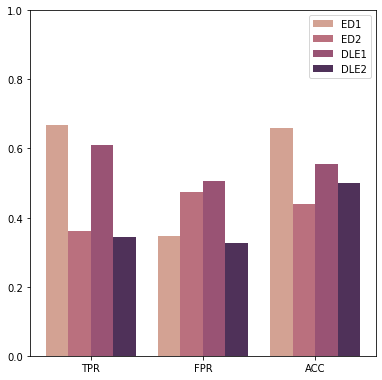

In [342]:
data = np.asarray([TPR_synth ,FPR_synth, acc_synth]).T
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,0.8,1.2])
labels = ['TPR', 'FPR', 'ACC']
x = np.arange(len(labels))  # the label locations
ax.bar(X + 0.00, data[0], color = '#d3a293', width = 0.20)
ax.bar(X + 0.20, data[1], color = '#ba707e', width = 0.20)
ax.bar(X + 0.40, data[2], color = '#995374', width = 0.20)
ax.bar(X + 0.60, data[3], color = '#4f3159', width = 0.20)
ax.legend(labels=['ED1', 'ED2', 'DLE1', 'DLE2'])
ax.set_xticks(x+0.30)
ax.set_ylim([0, 1])


ax.set_xticklabels(labels)


In [343]:
print(TPR_synth ,FPR_synth, acc_synth)

[0.66666667 0.36190476 0.60952381 0.34285714] [0.34736842 0.47368421 0.50526316 0.32631579] [0.66  0.44  0.555 0.5  ]


In [128]:
fn_synth

array([35., 67., 41., 69.])

In [133]:
tp_synth/(fn_synth+tp_synth)

array([0.66666667, 0.36190476, 0.60952381, 0.34285714])

In [135]:
tp_synth + tn_synth

array([132.,  88., 111., 100.])

In [136]:
df_labels

,Timestamp,Username,Unnamed: 2,Diagnosis of lesion,Is this image synthetic?,Level of certainty:,Diagnosis of lesion.1,Is this image synthetic?.1,Level of certainty:.1,Diagnosis of lesion.2,...,Level of certainty:.197,Diagnosis of lesion.198,Is this image synthetic?.198,Level of certainty:.198,Diagnosis of lesion.199,Is this image synthetic?.199,Level of certainty:.199,"Overall how convincing were the ""fake"" images?",Any comments for us in regards to the images or the process of the survey?,"If you would like to receive the results from the survey and the report that it will contribute to, please leave your email:"
0,2022/04/22 6:37:24 PM GMT+2,anna_frosen@hotmail.com,NaN,invasive melanoma,Yes,NaN,invasive melanoma,Yes,NaN,benign melanoma,...,NaN,benign melanoma,Yes,NaN,benign melanoma,Yes,NaN,NaN,NaN,NaN
1,2022/04/27 9:27:56 AM GMT+2,sam.polesie@gmail.com,Dermatologist,not melanoma,Yes,4.0,not melanoma,No,4.0,not melanoma,...,3.0,not melanoma,Yes,2.0,not melanoma,Yes,3.0,I would say they were very convincing. Hair st...,When you say malignant melanoma you automatica...,sam.polesie@gmail.com
2,2022/05/02 9:29:14 AM GMT+2,lisa.l.sjoblom@vgregion.se,Lay person (i.e. non-medical),not melanoma,Yes,3.0,malignant melanoma,No,3.0,not melanoma,...,2.0,not melanoma,No,2.0,not melanoma,Yes,2.0,Hard to say when you don't have the correct an...,No,NaN
3,2022/05/09 3:46:24 PM GMT+2,juulia.suvilehto@gmail.com,Deep learning expert,not melanoma,No,3.0,malignant melanoma,No,3.0,not melanoma,...,2.0,not melanoma,No,3.0,not melanoma,Yes,3.0,very convincing! well done! I was mainly focus...,NaN,NaN
4,2022/05/11 9:44:50 AM GMT+2,noora.neittaanmaki@vgregion.se,Dermatologist,not melanoma,No,4.0,malignant melanoma,Yes,3.0,not melanoma,...,4.0,not melanoma,Yes,4.0,not melanoma,No,4.0,"Some pretty convincing, some clearly fake",The images should be bigger (whole screen),noora.neittaanmaki@vgregion.se


In [19]:
tmp2 = np.round(np.sum(synth_matrix, axis=0)/4)
# tmp2 = synth_matrix[3]

In [29]:
np.sum(synth_matrix, axis=0)

array([ 0., -2., -4.,  0.,  0., -2.,  0.,  0., -2., -2.,  0.,  0.,  0.,
        0.,  2.,  0., -4., -4., -4.,  0.,  0., -2., -2., -2.,  2., -2.,
       -2.,  2.,  4., -2., -4.,  0.,  0., -2.,  2.,  0., -4., -2.,  0.,
       -4.,  0., -2., -2.,  2., -4., -2.,  2., -2., -4.,  0.,  2.,  0.,
        2.,  0.,  0.,  2., -4.,  2.,  0., -2., -4.,  0., -2.,  0., -2.,
       -2., -4.,  0.,  2.,  2., -2.,  0., -2., -2.,  0.,  0.,  0.,  0.,
       -4.,  2.,  2.,  2.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0., -2.,
       -2., -4.,  2.,  2.,  0.,  2.,  0.,  2.,  0.,  0., -2.,  4., -2.,
        4., -2., -2.,  2., -4., -4.,  0.,  0.,  0.,  2.,  2.,  4.,  0.,
        0., -2.,  2., -2., -2.,  2.,  0., -4.,  0.,  2., -2.,  0.,  0.,
        2., -2.,  2., -2.,  2.,  2.,  2.,  0.,  0.,  4., -2., -4., -2.,
        0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  2., -2.,  0.,  4., -2.,
        2.,  0.,  0.,  2., -2., -2.,  0., -2., -2.,  2., -4.,  0.,  2.,
       -2., -4., -2.,  0.,  2., -2.,  4., -2.,  0.,  2.,  0.,  0

In [424]:
# tmp3 = np.where((tmp2 + synth_label_gt)==-2)[0]

In [21]:
pred = (tmp2+1)/2
true = (synth_label_gt+1)/2

In [24]:
unq = np.array([x + 2*y for x, y in zip(pred, true)])
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

In [412]:
fn1 = np.asarray(fn)
len(df_gt.iloc[fn1])

35

In [416]:
fn2 = np.asarray(fn)
len(df_gt.iloc[fn2])

67

In [421]:
fn3 = np.asarray(fn)
len(df_gt.iloc[fn3])

41

In [427]:
fn4 = np.asarray(fn)
len(df_gt.iloc[fn4])

69

In [428]:
intersection = set(fn1) & set(fn2) & set(fn3) & set(fn4)

In [429]:
intersection

{2, 17, 36, 48, 60, 109, 141}

In [433]:
fn1 = np.asarray(fn)
df_gt.iloc[fn1]

,image_name,label,latent,edge,synthetic,order
2,seed2401_b.jpg,0,0,0,1,3
17,seed0274_m.jpg,1,0,0,1,18
36,latent_seed100206.jpg,1,1,0,1,37
48,seed1232_m.jpg,1,0,0,1,49
60,latent_seed100032.jpg,1,1,0,1,61
109,latent_seed100019.jpg,1,1,0,1,110
141,latent_seed100462.jpg,1,1,0,1,142


In [434]:
fn1 = np.asarray(fp)
df_gt.iloc[fn1]

,image_name,label,latent,edge,synthetic,order
104,imgsISIC_0738587.jpg,0,0,0,0,105
139,ISIC_0056511.jpeg,1,0,0,0,140
175,imgsISIC_0762591.jpg,0,0,0,0,176


In [435]:
fn1 = np.asarray(tp)
df_gt.iloc[fn1]

,image_name,label,latent,edge,synthetic,order
28,edge_seed0146_b.jpg,0,0,1,1,29
102,seed1760_b.jpg,0,0,0,1,103
115,seed0827_m.jpg,1,0,0,1,116
154,latent_seed100301.jpg,1,1,0,1,155
190,edge_seed0594_b.jpg,0,0,1,1,191


In [437]:
fn1 = np.asarray(tn)
df_gt.iloc[fn1]

,image_name,label,latent,edge,synthetic,order
16,imgsISIC_0720013.jpg,0,0,0,0,17
18,imgsISIC_0679155.jpg,0,0,0,0,19
30,ISIC_0000176.jpeg,1,0,0,0,31
39,imgsISIC_0029538.jpg,1,0,0,0,40
44,ISIC_0000022.jpeg,1,0,0,0,45
56,imgsISIC_0057147.jpg,1,0,0,0,57
66,imgsISIC_0678569.jpg,0,0,0,0,67
78,ISIC_0009868.jpeg,1,0,0,0,79
92,ISIC_0032845.jpeg,1,0,0,0,93
108,ISIC_0030828.jpeg,1,0,0,0,109


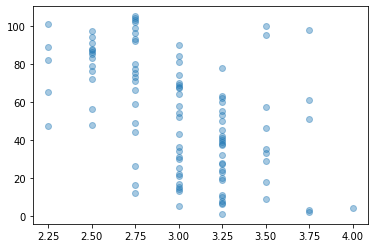

In [27]:
plt.scatter(np.mean(certainty_matrix, axis=0)[np.where(df_gt.synthetic == 1)[0]],np.linspace(1,105,105), alpha=0.4)

In [24]:
certainty_matrix[np.where(df_gt.synthetic == 1)[0]]

IndexError: ignored

In [26]:
certainty_matrix

array([[4., 4., 3., 4., 4., 3., 3., 5., 4., 4., 3., 3., 3., 4., 4., 4.,
        4., 4., 3., 3., 3., 2., 5., 3., 2., 3., 2., 3., 2., 2., 2., 2.,
        4., 3., 3., 3., 4., 4., 4., 4., 2., 3., 2., 2., 3., 3., 4., 3.,
        3., 2., 2., 2., 2., 4., 3., 4., 2., 3., 2., 2., 3., 3., 2., 2.,
        3., 2., 4., 2., 3., 5., 3., 3., 3., 3., 3., 4., 3., 3., 3., 2.,
        1., 3., 3., 1., 3., 3., 3., 1., 2., 3., 2., 3., 2., 4., 4., 4.,
        3., 4., 3., 3., 3., 1., 2., 3., 1., 2., 4., 4., 3., 2., 3., 2.,
        2., 5., 3., 2., 2., 2., 2., 5., 2., 2., 2., 2., 3., 3., 1., 2.,
        2., 3., 3., 4., 3., 3., 4., 2., 2., 5., 2., 5., 2., 2., 2., 2.,
        2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 2., 1., 3., 2.,
        2., 2., 2., 2., 3., 2., 2., 3., 2., 2., 3., 2., 2., 3., 2., 2.,
        2., 2., 3., 4., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 4., 2.,
        3., 2., 2., 3., 3., 3., 2., 3.],
       [3., 3., 4., 3., 4., 3., 3., 4., 4., 3., 4., 4., 4., 3., 3., 3.,
        3., 4., 3., 3.,